# Does the `fit_residual` idea work on other datasets?

**TLDR;** When trying to predict MedHouseVal with the california housing dataset, creating a dense model with `fit_residual` makes it worse.

When `fit_residual=True`, we build a model that has direct access to the results of a baseline model - in the hope that the model can learn to correct the errors of the baseline with a result that is;
- more accurate than without `fit_residual` and/or
- achieved with less compute / smaller models.

We had some [good results](https://github.com/pete88b/deep_learning_with_python/blob/main/10.2_temperature_forecasting_part2.ipynb) using `fit_residual` to forcast temperature but ... california housing is quite different;
- there is no time dimension
- there is no common sense baseline
    - or maybe I just don't have enough common sense to see it (o:
    - so we try using `LinearRegression` and `DecisionTreeRegressor` as a baseline

Note: Using `tensorflow/tensorflow:latest-gpu-jupyter` we can `pip install sklearn pandas` via a Jupyter terminal.

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
try:
    from utils.plot_history import *
except ModuleNotFoundError:
    if not Path('plot_history.py').is_file():
        !wget https://raw.githubusercontent.com/pete88b/deep_learning_with_python/main/utils/plot_history.py
    from plot_history import *

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-loqir5fw because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Quick look at the data

In [2]:
df = fetch_california_housing(data_home='data', as_frame=True)['frame']
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [3]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


# Load the data as numpy

In [4]:
dataset = fetch_california_housing(data_home='data')
X_full, y_full, feature_names, target_names = [dataset[k] for k in ['data', 'target', 'feature_names', 'target_names']]
X_full.shape, y_full.shape, feature_names, target_names

((20640, 8),
 (20640,),
 ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 ['MedHouseVal'])

# Work out how many samples we'll have in each dataset

In [5]:
n_train_samples = len(y_full) // 2
n_val_samples = len(y_full) // 4
n_test_samples = len(y_full) - n_train_samples - n_val_samples

# Spilt data into train, val, test and scale inputs

In [6]:
def split_and_scale_data(X, y):
    X_train, y_train = X[:n_train_samples], y[:n_train_samples]
    X_val, y_val = X[n_train_samples:n_train_samples+n_val_samples], y[n_train_samples:n_train_samples+n_val_samples]
    X_test, y_test = X[n_train_samples+n_val_samples:], y[n_train_samples+n_val_samples:]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val, X_test = [scaler.transform(X) for X in [X_val, X_test]]
    return X_train, y_train, X_val, y_val, X_test, y_test, scaler

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test, scaler = split_and_scale_data(X_full, y_full)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((10320, 8), (10320,), (5160, 8), (5160,))

# Create a baseline model

`LinearRegression` is quite a bit more accurate than `DecisionTreeRegressor` so we'll use it as our baseline

In [8]:
ml_model = LinearRegression().fit(X_train, y_train)
print('Val MAE', mean_absolute_error(y_val, ml_model.predict(X_val)))
print('Test MAE', mean_absolute_error(y_test, ml_model.predict(X_test)))

Val MAE 0.5054755000767698
Test MAE 0.5753288612466615


I was hoping that a really small tree would be good enough - but `DecisionTreeRegressor(max_depth=3)` gives us Val MAE 0.61 and Test MAE 0.68. Note sure what a good baseline is for this problem, but I think we need to do better than that (o:

Note: Using the `DecisionTreeRegressor` hurt the dense model less than `LinearRegression`, when `fit_residual=True`.

In [9]:
# ml_model = DecisionTreeRegressor(min_samples_leaf=40).fit(X_train, y_train)
# print('Val MAE', mean_absolute_error(y_val, ml_model.predict(X_val)))
# print('Test MAE', mean_absolute_error(y_test, ml_model.predict(X_test)))
# plt.figure(figsize=(16,5))
# plot_tree(ml_model, fontsize=10) # Plot the whole tree even though we can only read the first few branches
# plt.show()

In [10]:
def new_model(fit_residual=False):
    "Create a simple fully connected nn"
    kernel_regularizer = regularizers.l2(1e-2)
    inputs = layers.Input(shape=(X_train.shape[-1]))
    x = keras.layers.Dense(64, activation='relu', kernel_regularizer=kernel_regularizer)(inputs)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(64, activation='relu', kernel_regularizer=kernel_regularizer)(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(1)(x)
    if fit_residual:
        x = tf.expand_dims(inputs[:, -1] * scaler.scale_[-1] + scaler.mean_[-1], -1) + x
    model = keras.models.Model(inputs, x)
    model.compile(
        optimizer='rmsprop',
        loss=keras.losses.mean_squared_error,
        metrics=['mae']
    )
    return model

In [11]:
def compile_and_fit(model, model_tag):
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    kwargs = dict(monitor='val_mae', verbose=1)
    cbs = [callbacks.ModelCheckpoint(f'data/models/california_{model_tag}.keras', 
                                     save_best_only=True, **kwargs),
           callbacks.EarlyStopping(patience=2, **kwargs)]
    history = model.fit(X_train, y_train,
                        batch_size=128,
                        epochs=20,
                        validation_data=(X_val, y_val),
                        callbacks=cbs)
    del history.history['loss'] # we'll just plot mae
    plot_history(history, ignore_first_n=0)

In [12]:
def evaluate_model(model_tag):
    model = keras.models.load_model(f'data/models/california_{model_tag}.keras')
    print(f"Test MAE: {model.evaluate(X_test, y_test)[1]:.2f} for model tag: {model_tag}")

Epoch 1/20
68/81 [========================>.....] - ETA: 0s - loss: 3.3358 - mae: 1.1116
Epoch 1: val_mae improved from inf to 0.67055, saving model to data/models/california_dense_0.keras
81/81 [==============================] - 1s 5ms/step - loss: 3.2382 - mae: 1.0682 - val_loss: 1.4134 - val_mae: 0.6706
Epoch 2/20
81/81 [==============================] - ETA: 0s - loss: 1.7476 - mae: 0.7602
Epoch 2: val_mae improved from 0.67055 to 0.64432, saving model to data/models/california_dense_0.keras
81/81 [==============================] - 0s 3ms/step - loss: 1.7476 - mae: 0.7602 - val_loss: 1.1667 - val_mae: 0.6443
Epoch 3/20
79/81 [============================>.] - ETA: 0s - loss: 1.4319 - mae: 0.6873
Epoch 3: val_mae improved from 0.64432 to 0.55627, saving model to data/models/california_dense_0.keras
81/81 [==============================] - 0s 3ms/step - loss: 1.4251 - mae: 0.6860 - val_loss: 0.9141 - val_mae: 0.5563
Epoch 4/20
81/81 [==============================] - ETA: 0s - loss: 

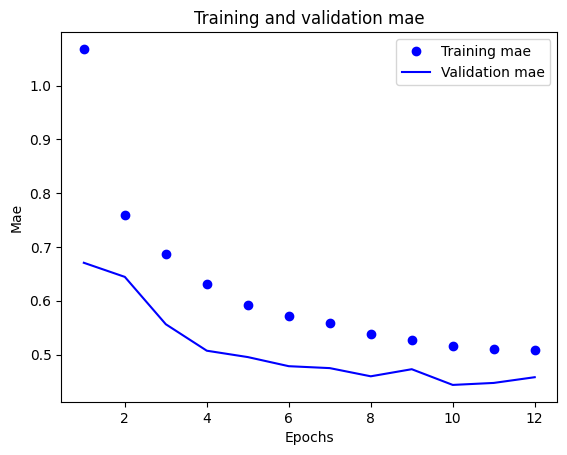

In [13]:
model = new_model()
compile_and_fit(model, 'dense_0')

In [14]:
evaluate_model('dense_0')

162/162 [==============================] - 0s 1ms/step - loss: 0.6468 - mae: 0.5113
Test MAE: 0.51 for model tag: dense_0


# Add the "ML model" predictions as an extra feature

In [15]:
X_full_1 = np.concatenate([X_full, ml_model.predict(X_full)[:,None]], axis=1)
X_train, y_train, X_val, y_val, X_test, y_test, scaler = split_and_scale_data(X_full_1, y_full)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((10320, 9), (10320,), (5160, 9), (5160,))

# Now we can create a model that uses `fit_residual`

Epoch 1/20
78/81 [===========================>..] - ETA: 0s - loss: 1753.3737 - mae: 41.2968
Epoch 1: val_mae improved from inf to 30.91929, saving model to data/models/california_dense_1.keras
81/81 [==============================] - 1s 5ms/step - loss: 1731.9683 - mae: 41.0111 - val_loss: 997.3923 - val_mae: 30.9193
Epoch 2/20
78/81 [===========================>..] - ETA: 0s - loss: 658.6127 - mae: 21.2213
Epoch 2: val_mae improved from 30.91929 to 9.50454, saving model to data/models/california_dense_1.keras
81/81 [==============================] - 0s 3ms/step - loss: 647.5510 - mae: 20.9717 - val_loss: 169.0550 - val_mae: 9.5045
Epoch 3/20
79/81 [============================>.] - ETA: 0s - loss: 294.1333 - mae: 12.3895
Epoch 3: val_mae improved from 9.50454 to 6.38091, saving model to data/models/california_dense_1.keras
81/81 [==============================] - 0s 3ms/step - loss: 291.5994 - mae: 12.3552 - val_loss: 108.8775 - val_mae: 6.3809
Epoch 4/20
78/81 [=====================

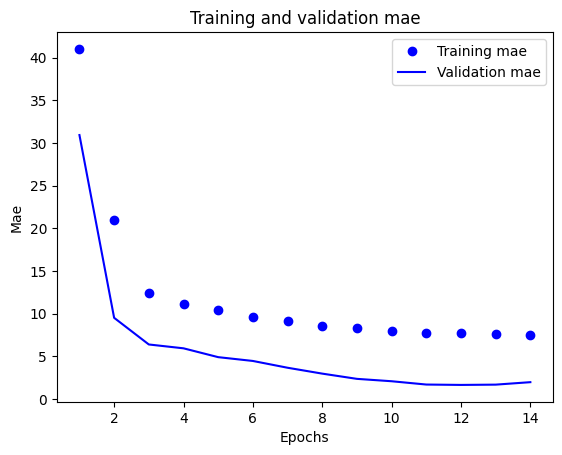

In [16]:
model = new_model(True)
compile_and_fit(model, 'dense_1')

In [17]:
evaluate_model('dense_1')

162/162 [==============================] - 0s 1ms/step - loss: 273.3255 - mae: 2.6836
Test MAE: 2.68 for model tag: dense_1


# Lets take a look at some predictions

In [26]:
import pandas as pd
model_0, model_1 = [keras.models.load_model(f'data/models/california_dense_{i}.keras') for i in [0,1]]
df = pd.DataFrame(dict(y_test=y_test,
                       ml_model=ml_model.predict(X_test[:, :8]), 
                       model_0=np.squeeze(model_0.predict(X_test[:, :8])), 
                       model_1=np.squeeze(model_1.predict(X_test))))
df.insert(2, 'ml_model_diff', df['ml_model'] - df['y_test'])
df.insert(4, 'model_0_diff', df['model_0'] - df['y_test'])
df['model_1_diff'] = df['model_1'] - df['y_test']

# See where the dense model has the least agreement with the tree

In [28]:
df.sort_values(by='model_0_diff', key=abs, ascending=False)

,y_test,ml_model,ml_model_diff,model_0,model_0_diff,model_1,model_1_diff
3021,1.31300,7.031888,5.718888,6.377266,5.064266,8.710068,7.397068
4062,4.50000,0.764266,-3.735734,0.929331,-3.570669,1.883251,-2.616749
2984,5.00001,2.063860,-2.936150,1.518786,-3.481224,3.254131,-1.745879
172,5.00001,1.329170,-3.670840,1.595546,-3.404464,-0.195637,-5.195647
1076,4.75000,1.708415,-3.041585,1.445669,-3.304331,2.779682,-1.970318
...,...,...,...,...,...,...,...
5159,0.89400,0.462152,-0.431848,0.894777,0.000777,2.516216,1.622216
1101,1.47600,1.739076,0.263076,1.475406,-0.000594,3.349342,1.873342
1730,2.55000,2.033823,-0.516177,2.550298,0.000298,3.344990,0.794990
973,0.98200,0.979196,-0.002804,0.982281,0.000281,4.186161,3.204161


# See where the dense model with `fit_residual` has the least agreement with the tree

We don't have to look very hard to see that the model with `fit_residual` is making some really bad predictions &darr;

In [29]:
df.sort_values(by='model_1_diff', key=abs, ascending=False)

,y_test,ml_model,ml_model_diff,model_0,model_0_diff,model_1,model_1_diff
3526,1.37500,-4.457526,-5.832526,-0.080494,-1.455494,-1084.633301,-1086.008301
1189,3.50000,-1.177644,-4.677644,0.351913,-3.148087,-429.011505,-432.511505
1933,0.28300,2.158222,1.875222,2.091531,1.808531,-23.957333,-24.240333
940,1.62500,2.104311,0.479311,0.594015,-1.030985,-20.701248,-22.326248
4971,3.21300,3.338905,0.125905,3.265853,0.052853,-15.715734,-18.928734
...,...,...,...,...,...,...,...
515,5.00001,3.030217,-1.969793,3.277707,-1.722303,5.008911,0.008901
193,5.00001,2.979270,-2.020740,3.348223,-1.651787,4.993153,-0.006857
65,2.49100,2.454731,-0.036269,2.343484,-0.147516,2.486137,-0.004863
3349,0.64600,0.399339,-0.246661,0.883560,0.237560,0.643715,-0.002285
